# Good Faith Newcomer Prediction

Aaron has a labeled dataset of newcomers to English Wikipedia. Newcomers are labeled as good-faith or bad-faith based on Wikipedians' judgements of the newcomers' edits in their first edit session. Aaron used STiki scores to construct a bayesian prediction model of good-faith newcomers. In this notebook, I'll try to reproduce his results using ORES scores as well as try out some other modeling strategies. The data for this notebook comes from the "Get Newcomer Data" notebook.

In [1]:
% matplotlib inline
import pandas as pd
from scipy.stats import beta
import numpy as np
from sklearn.metrics import roc_auc_score
import datetime
import matplotlib.pyplot as plt 
from math import log, factorial, exp
import os

### Load newcomer labels and revisions

In [2]:
labels_df = pd.read_csv('../data/newcomer_labels.csv')
revisions_df = pd.read_csv('../data/newcomer_revisions.csv')

In [3]:
print("# labeled newcomers: ", labels_df.shape[0])

# labeled newcomers:  1063


In [4]:
print("# newcomers for which we have ORES scored revisions: ", len(revisions_df['userid'].unique()))

# newcomers for which we have ORES scored revisions:  955


In [5]:
revisions_df = revisions_df.merge(labels_df, left_on = 'userid', right_on = 'user_id')
del revisions_df['userid']

In [6]:
labels_df['goodfaith_label'].value_counts()

True     875
False    188
Name: goodfaith_label, dtype: int64

### Get newcomer first edit session, main namespace edits, etc

In [7]:
def get_main_ns_contribs(df):
    return df.query("ns==0")

def parse_dt(s):
    return datetime.datetime.strptime(s, '%Y-%m-%dT%H:%M:%SZ')

def get_first_edit_sessions(df, gap = 60):
    """
    Remove any revisions/rows from df that are not part of an
    editor's first edit session
    """
    
    user_groups = df.groupby('user_id')
    fes_rows = []
    
    for user_id, user_df in user_groups:
        user_rows = list(user_df.T.to_dict().values())
        user_rows.sort(key = lambda x: x['timestamp'])
        
        if len(user_rows) <= 1:
            fes_rows += user_rows
        else:
            session = [user_rows[0]]
            t_prev = parse_dt(user_rows[0]['timestamp'])
            for x in user_rows[1:]:
                t_curr = parse_dt(x['timestamp'])
                delta = t_curr - t_prev
                
                if delta > datetime.timedelta(minutes=gap):
                    break
                else:
                    t_prev = t_curr
                    session.append(x)
            fes_rows += session
    return pd.DataFrame(fes_rows)

def get_first_edits(df):
    """
    Collect the first edit after registering
    for each editor from df
    """
    return df.sort_values('timestamp').groupby('user_id').first()


In [8]:
# first edit session contrubutions
fes_revs_df = get_first_edit_sessions(revisions_df)
# main namespace contributions (first 100)
ns0_revs_df = get_main_ns_contribs(revisions_df)
# first edit session main namespace contrubutions
ns0_fes_revs_df = get_first_edit_sessions(ns0_revs_df)
# first main namespace edit
ns0_fe_revs_df = get_first_edits(ns0_revs_df)

# Learning

In [9]:
from sklearn.base import BaseEstimator, ClassifierMixin
import random

def get_X_y(revisions_df, model):
    """
    Utility for geting "features" and labels for snuggle model.
    Takes the a dataframe of scored revisions (revisions_df)
    and returns a series of user score lists and user labels
    """
    
    user_scores = []
    
    for user_id, user_df in revisions_df.groupby('user_id'):
        scores = list(user_df[model])
        goodfaith = user_df.iloc[0]['goodfaith_label']
        row = {'scores': scores, 'goodfaith_label': goodfaith, 'user_id' : user_id}
        user_scores.append(row)
    
    df = pd.DataFrame(user_scores).sample(frac=1)
    df.index = df.user_id
    return df['scores'], df['goodfaith_label']


def fit_beta(data):
    """
    Method of moments method for fitting beta distribution
    """
    mean = np.mean(data)
    var = np.var(data,ddof=1)
    a = mean**2*(1-mean)/var-mean
    return a, a*(1-mean)/mean
    
    
class SnuggleScorer(BaseEstimator, ClassifierMixin):

    def __init__(self, ):
        self.EPSILON = 0.005
    
    def fit(self, X, y):
        """
        X is a series of lists, where each element in the list
        is an ORES edit quality score for a revision for a given editor
        """
        
        df = pd.DataFrame({"goodfaith_label": y, "scores": X})
        
        df_0 = df.query('goodfaith_label == 0')
        self.scores_0 = [c for cs in df_0['scores'] for c in cs]
        
        df_1 = df.query('goodfaith_label == 1')
        self.scores_1 = [c for cs in df_1['scores'] for c in cs]
        
        self.p_0_prior = float(len(df_0)) / (len(df_0) + len(df_1))
        self.p_1_prior = 1 - self.p_0_prior
        
        self.a0, self.b0 = fit_beta(self.scores_0)
        self.a1, self.b1 = fit_beta(self.scores_1)
        self.model_0 = beta(self.a0, self.b0)
        self.model_1 = beta(self.a1, self.b1)
       
        return self
        
    
    def beta_likelihood(self, scores, model):
        """
        Straight from https://github.com/wikimedia/analytics-snuggle/blob/master/snuggle/desirability.py#L18-L27
        """
        log_p = log(factorial(len(scores)))
        for score in scores:
            log_p += log(
            model.cdf(min(score + self.EPSILON, 1)) - 
            model.cdf(max(score - self.EPSILON, 0.005))
            )

        return exp(log_p)
        

    def predict_proba_single(self, user_scores):
        """
        Straight from https://github.com/wikimedia/analytics-snuggle/blob/master/snuggle/desirability.py#L30-L34
        """
        
        p_0 = self.beta_likelihood(user_scores, self.model_0) * self.p_0_prior
        p_1 = self.beta_likelihood(user_scores, self.model_1) * self.p_1_prior
        
        return p_1 / (p_1 + p_0)
    
    def predict_proba(self, users):
        pred = np.array([self.predict_proba_single(c) for c in users])
        return np.vstack([1-pred, pred]).T

        
    def plot_betas(self):
        
        """
        Plot distribution over damaging scores for revisions
        in first edit sessions of good-faith and not good-faith newcomers
        """
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
        ax1.set_title("Good Faith Newbies")
        ax1.hist(self.scores_1, normed = True)
        x = np.linspace(0, 1, 100)
        rv = beta(self.a1, self.b1)
        ax1.plot(x, rv.pdf(x), 'k-', lw=2, label='pdf')
        
        ax2.set_title("Bad Faith Newbies")
        ax2.hist(self.scores_0, normed = True)
        x = np.linspace(0, 1, 100)
        rv = beta(self.a0, self.b0)
        ax2.plot(x, rv.pdf(x), 'k-', lw=2, label='pdf')
        
        ax1.set_xlabel("ORES scores")
        ax2.set_xlabel("ORES scores")
        
        return f


In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
models = ['reverted', 'goodfaith', 'damaging']
CV = StratifiedKFold(n_splits=5)

In [11]:
print("Score first edit session:\n")
for model in models:
    X, y = get_X_y(ns0_fes_revs_df, model)
    scores = cross_val_score(SnuggleScorer(), X, y, cv=CV, scoring = "roc_auc")
    print("%s ROC: %0.3f (+/- %0.3f)" % (model, scores.mean(), scores.std() ))

Score first edit session:

reverted ROC: 0.775 (+/- 0.065)
goodfaith ROC: 0.780 (+/- 0.033)
damaging ROC: 0.793 (+/- 0.035)


In [12]:
print("Score up to 50 edits: \n")
for model in models:
    X, y = get_X_y(ns0_revs_df, model)
    scores = cross_val_score(SnuggleScorer(), X, y, cv=CV, scoring = "roc_auc")
    print("%s ROC: %0.3f (+/- %0.3f)" % (model, scores.mean(), scores.std()))

Score up to 50 edits: 

reverted ROC: 0.766 (+/- 0.059)
goodfaith ROC: 0.774 (+/- 0.061)
damaging ROC: 0.783 (+/- 0.054)


Observing more user edits beyond the first edit session does not improve the model. 

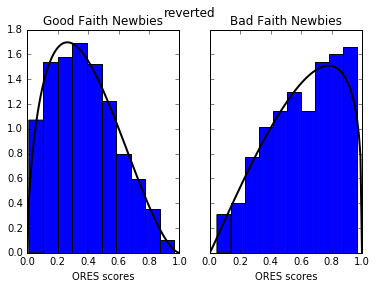

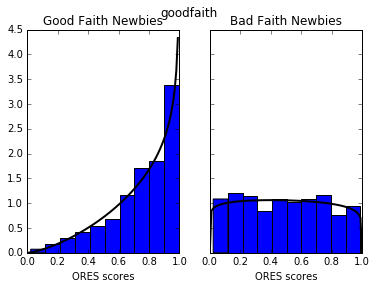

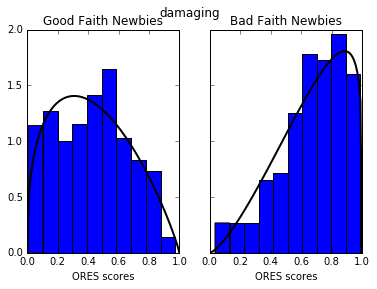

In [13]:
# plot the beta distributions for each model
for model in models:
    X, y = get_X_y(ns0_fes_revs_df, model)
    f = SnuggleScorer().fit(X, y).plot_betas()
    f.suptitle(model,fontsize=12)

The Snuggle paper reports an ROC of .88. We will need to figure out where the discrepancy comes from:
1. conceptual or implementation error in reproduction
2. difference in accuracy/semantics between ORES and STiki scores
3. small sample size effect in paper (n=150 vs n=1000)

### Random Forest Model

The Snuggle model is essentially a naive bayes classifier. Lets try a different learning algorithm.

In [14]:
from time import time
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

In [15]:
models = ['reverted', 'goodfaith', 'damaging']

def get_summary_stat_features(user_id, revisions_df ,models, max_edits = 100):
    """
    Return various summary stats of ORES scores for edit in first edit session
    """
    
    feature_sets = []
    
    for model in models:
        scores = list(revisions_df.query("user_id==%d" % user_id)[model][:max_edits])
        num_edits = len(scores)
        median_score = np.median(scores or [0])
        max_score = max(scores or [0])
        hist =  np.histogram(scores)[0] / max(1, num_edits)
        cdf = np.cumsum(hist)
        feature_sets += [np.array([num_edits, median_score, max_score ]), hist, cdf]
        
    features = np.concatenate(feature_sets)
    return pd.Series(features)

def get_snuggle_features(revisions_df, models):
    features = {}
    
    for model in models: 
        X, y = get_X_y(revisions_df, model)
        SC = SnuggleScorer().fit(X, y)
        features[model+"_snuggle_score"] = X.apply(SC.predict_proba_single)
    return pd.DataFrame(features)

In [16]:
df_users = revisions_df[['user_id', 'goodfaith_label']].drop_duplicates()
df_users.index = df_users.user_id

summary_stat_features = df_users['user_id'].apply(lambda x: get_summary_stat_features(x, ns0_fes_revs_df, models))
snuggle_features = get_snuggle_features(ns0_fes_revs_df, models)


X = pd.concat([summary_stat_features, snuggle_features ], axis = 1)
X['goodfaith_label'] = df_users['goodfaith_label']
X = X.dropna()
y = X['goodfaith_label']
del X['goodfaith_label']

In [17]:
# build a classifier
clf = RandomForestClassifier()


# Utility function to report best scores
def report(results, n_top=1):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  2*results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, 10, None],
              "max_features": sp_randint(1, 3),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
              "n_estimators": sp_randint(20, 100)}

# run randomized search
n_iter_search = 30
random_search = RandomizedSearchCV(clf,
                                   param_distributions=param_dist, 
                                   n_iter=n_iter_search,
                                   scoring = "roc_auc", 
                                   cv = CV)

In [19]:
# combine all 3 snuggle models
snuggle_feature_names = ['damaging_snuggle_score', 'goodfaith_snuggle_score', 'reverted_snuggle_score']
random_search.fit(X[snuggle_feature_names], y)
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.800 (std: 0.110)
Parameters: {'min_samples_split': 3, 'bootstrap': True, 'max_depth': 3, 'max_features': 2, 'min_samples_leaf': 5, 'criterion': 'gini', 'n_estimators': 58}



In [20]:
# use summary stats from all 3 models
random_search.fit(X[X.columns.difference(snuggle_feature_names)], y)
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.774 (std: 0.158)
Parameters: {'min_samples_split': 7, 'bootstrap': True, 'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 4, 'criterion': 'entropy', 'n_estimators': 36}



In [21]:
# use summary stats and snuggle features from all 3 models
random_search.fit(X, y)
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.778 (std: 0.139)
Parameters: {'min_samples_split': 6, 'bootstrap': True, 'max_depth': None, 'max_features': 2, 'min_samples_leaf': 8, 'criterion': 'gini', 'n_estimators': 39}



It appears as if combining different Snuggle models and adding the features based on summary stats do not meaningfully improve the single Snuggle model trained on ORES damaging scores.